In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
import LEN_Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH


In [2]:
TH = TH()

mimicDF = TH.get_mimic()

mimicDF

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47084,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47085,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47086,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
mimicDF.describe()

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
count,47088.000000,47088.000000,484.000000,481.000000,705.000000,245.000000,31415.000000,31503.000000,31504.000000,8601.000000,...,12981.000000,14768.000000,14714.000000,4352.000000,2485.000000,32961.000000,85.000000,26516.000000,331.000000,2118.000000
mean,151079.910805,0.039755,630.123967,954.301455,67.382553,2.721633,77.058157,57.226709,117.544502,40.565399,...,33.217492,987.290546,1917.421073,96.799012,138.022942,97.267665,64.988235,37.235334,2.529305,12.747691
std,29378.613191,0.195386,1245.805613,2384.326867,5.448469,0.584693,14.324177,11.197415,21.311674,7.078312,...,10.474703,363.504762,608.801780,2.659592,5.435978,3.083466,10.518118,1.399548,3.004787,5.523420
min,100059.000000,0.000000,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,42.000000,1.210000,0.000000,43.000000,0.000000,0.000000,1.900000
25%,126241.000000,0.000000,25.000000,49.000000,64.000000,2.400000,68.000000,50.000000,103.000000,36.000000,...,26.168200,737.500000,1494.877533,96.000000,136.000000,96.000000,58.000000,36.900002,0.600000,9.000000
50%,151857.000000,0.000000,97.000000,137.000000,68.000000,2.700000,75.000000,56.000000,115.000000,40.000000,...,31.460699,931.028503,1841.049988,97.000000,138.000000,98.000000,65.000000,37.299999,1.400000,11.900000
75%,176484.000000,0.000000,554.750000,797.000000,70.000000,3.000000,84.000000,63.000000,129.000000,44.000000,...,38.118801,1169.229980,2244.340088,98.000000,140.000000,100.000000,71.000000,37.700001,3.300000,15.500000
max,199998.000000,1.000000,8100.000000,23060.000000,160.000000,4.400000,287.000000,191.000000,255.000000,91.000000,...,179.212997,3784.620117,6000.000000,100.000000,164.000000,100.000000,100.000000,46.500000,16.400000,48.300000


In [4]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [71]:
# for id in mimicDF['PatientID'].unique()[:1]:
#     patientDF = mimicDF[mimicDF['PatientID'] == id]
#     display(patientDF)

In [5]:


patients = TH.get_patients()

print(len(patients))

1126


In [70]:
print(patients[0].patientID, '\n', patients[0].data)

178177 
     Mortality14Days  ALT  AST  Admit Ht  Albumin  Arterial BP Mean  \
0                 0  NaN  NaN       NaN      NaN               NaN   
1                 0  NaN  NaN       NaN      NaN               NaN   
2                 0  NaN  NaN       NaN      NaN               NaN   
3                 0  NaN  NaN       NaN      NaN               NaN   
4                 0  NaN  NaN       NaN      NaN               NaN   
5                 0  NaN  NaN       NaN      NaN               NaN   
6                 0  NaN  NaN       NaN      NaN               NaN   
7                 0  NaN  NaN       NaN      NaN               NaN   
8                 0  NaN  NaN       NaN      NaN               NaN   
9                 0  NaN  NaN       NaN      NaN               NaN   
10                0  NaN  NaN       NaN      NaN               NaN   
11                0  NaN  NaN       NaN      NaN               NaN   
12                0  NaN  NaN       NaN      NaN               NaN   
13         

In [95]:
nullCount = {}



for patient in patients:

    for column in patient.data.columns:

        if patient.data[column].isnull().all():

            if column not in nullCount:
                nullCount[column] = int(patient.data[column].isnull().all())
            else:
                nullCount[column] += int(patient.data[column].isnull().all())

nullCount = dict(sorted(nullCount.items(), key=lambda item: item[1]))


display(nullCount)


{'Platelets': 25,
 'Arterial BP [Diastolic]': 29,
 'Arterial BP [Systolic]': 29,
 'Arterial BP Mean': 30,
 'CVP': 36,
 'Arterial pH': 43,
 'Hemoglobin': 45,
 'Arterial PaCO2': 51,
 'Arterial PaO2': 51,
 'SVR': 57,
 'Ionized Calcium': 73,
 'SVRI': 77,
 'SVI': 123,
 'Resp Rate (Spont)': 219,
 'SaO2': 232,
 'CaO2': 313,
 'Potassium': 381,
 'Glucose': 382,
 'Sodium': 384,
 'BUN': 388,
 'Creatinine': 388,
 'Chloride': 389,
 'WBC': 395,
 'Daily Weight': 408,
 'INR': 442,
 'PTT': 444,
 'Magnesium': 445,
 'Admit Ht': 463,
 'NBP [Systolic]': 501,
 'NBP [Diastolic]': 516,
 'NBP Mean': 519,
 'Fibrinogen': 795,
 'ALT': 873,
 'AST': 876,
 'Total Bili': 955,
 'Albumin': 983,
 'LDH': 991,
 'SvO2': 1077,
 'Respiratory Rate (spontaneous)': 1125}

Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP']
False
False
False
False
False


In [238]:

patientsKept = []
numPatientsKept = []

print(list(nullCount.keys())[:1])


for i in range(len(list(patient.data.columns)[:15])):

    # print(i)

    columnsToKeep = list(nullCount.keys())[:i+1]

    print(f"Keeping {columnsToKeep}")

    nonNullPatients = []

    for patient in patients:

        for col in columnsToKeep:

            if patient.data[col].isnull().all():
                break
        
        else:
            patient.clusteringColumns = patient.data[columnsToKeep]
            # print(patient.clusteringColumns)
            nonNullPatients.append(copy.copy(patient))
        
    
    print(nonNullPatients[0].clusteringColumns.columns)


    # nonNullPatients = [patient for patient in patients if not patient.data[columnsToKeep].isnull().all().all()]


    print(len(nonNullPatients))

    patientsKept.append(nonNullPatients)
    numPatientsKept.append(len(nonNullPatients))

print(len(patientsKept))

# display(patients[0].data[columnsToKeep])

['Platelets']
Keeping ['Platelets']
Index(['Platelets'], dtype='object')
1101
Keeping ['Platelets', 'Arterial BP [Diastolic]']
Index(['Platelets', 'Arterial BP [Diastolic]'], dtype='object')
1076
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]'], dtype='object')
1076
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean'],
      dtype='object')
1075
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP'],
      dtype='object')
1057
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP', 'Arterial pH']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial 

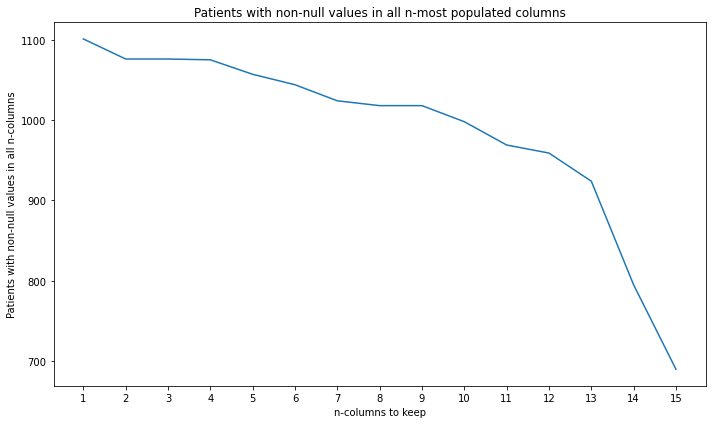

In [239]:
patientsKeptDF = pd.DataFrame(data=numPatientsKept)

patientsKeptDF['n_col'] =list(range(1, len(patientsKeptDF)+1))

patientsKeptDF = patientsKeptDF.set_index('n_col')



fig = plt.figure(figsize=(10, 6))

plt.xticks(patientsKeptDF.iloc[:,0].index)
plt.xlabel("n-columns to keep")
plt.ylabel("Patients with non-null values in all n-columns")
plt.title("Patients with non-null values in all n-most populated columns")
plt.plot(patientsKeptDF.iloc[:,0])
plt.tight_layout()
plt.show()

#### Sharp drop off after 12 columns so will keep around 1000 patients with at least some data in the top 12 columns

In [242]:
for patients in patientsKept:
    print(patients[0].clusteringColumns.columns)

Index(['Platelets'], dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]'], dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]'], dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin',
       'Arterial PaCO2'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systoli

In [247]:
clusteringPatients = patientsKept[11]

In [248]:
# columnsToInterpolate = ['Glucose']

noInterpolation = 0

for patient in clusteringPatients:

    # print(patient.clusteringColumns)

    patient.interpolatedData = pd.DataFrame()

    for column in patient.clusteringColumns.columns:

        try:
            # print(patient.data.isnull().all())
            patient.interpolatedData[column] = patient.clusteringColumns[column].interpolate(method='polynomial', order=2, limit_direction='both')


            # print(patient.interpolatedData)
            
            patient.interpolatedData[column] = patient.interpolatedData[column].interpolate(method='linear', limit_direction='both', fill_value='extrapolate')
    
        except ValueError:
            patient.interpolatedData[column] = patient.clusteringColumns[column].fillna(patient.clusteringColumns[column].mean())
            noInterpolation += 1

        # print(patient.interpolatedData)

# Is this true?
print(f"{noInterpolation}/{len(patients)} patients have no missing values")

1166/690 patients have no missing values


In [249]:
display(clusteringPatients[1].interpolatedData.columns)

Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin',
       'Arterial PaCO2', 'Arterial PaO2', 'SVR', 'Ionized Calcium', 'SVRI'],
      dtype='object')

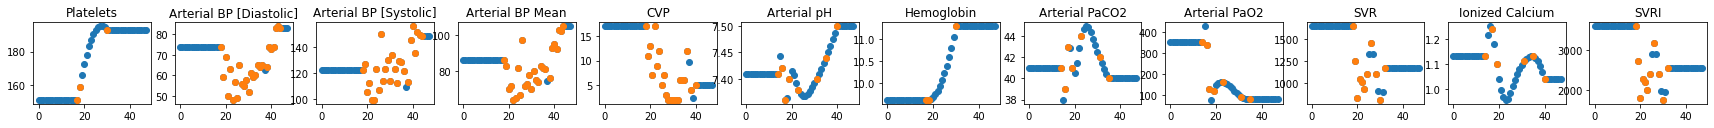

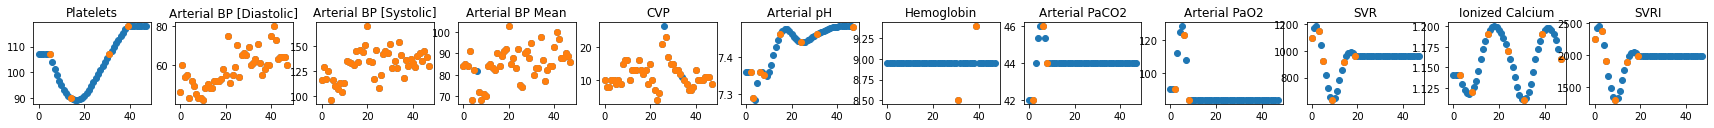

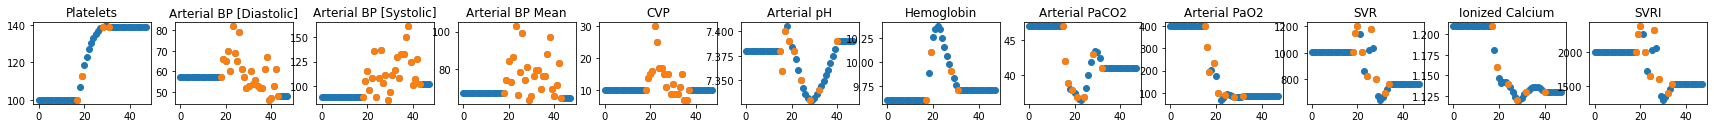

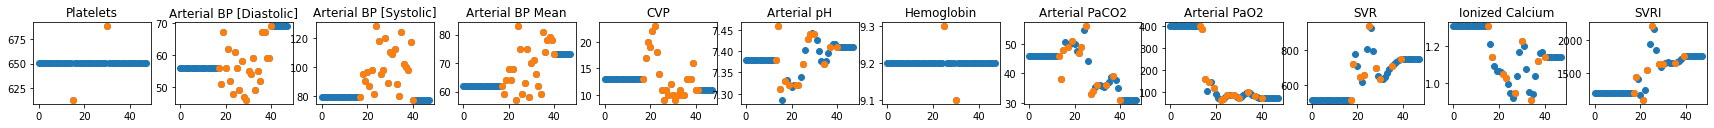

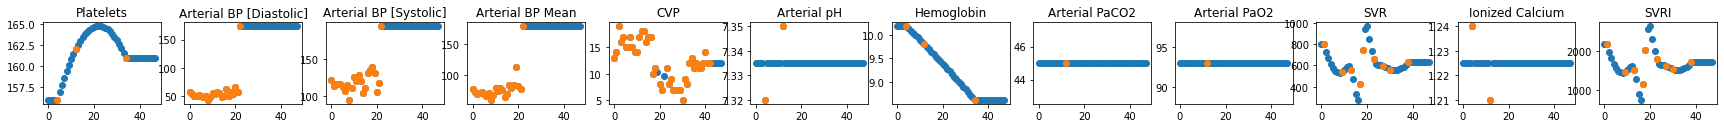

In [254]:

for i in range(len(clusteringPatients[:5])):

    # display(clusteringPatients[i].interpolatedData.head())

    fig = plt.figure(figsize = (30, 1.5))

    for idx, col in enumerate(clusteringPatients[i].interpolatedData.columns):
        plt.subplot(1, len(clusteringPatients[i].interpolatedData.columns), idx+1)

        plt.scatter(clusteringPatients[i].interpolatedData.index, clusteringPatients[i].interpolatedData[col])
        plt.scatter(clusteringPatients[i].clusteringColumns.index, clusteringPatients[i].clusteringColumns[col])
        plt.title(f"{col}")

    plt.show()



In [63]:
dataDF = pd.DataFrame([patient.interpolatedData['Glucose'].values for patient in patients]).fillna(patient.interpolatedData["Glucose"].mean())

data = dataDF.to_numpy()

dataFormatted = to_time_series_dataset([*data])

# dataFormatted = TimeSeriesScalerMeanVariance().fit_transform(data)

print(data.shape)
print(dataFormatted.shape)


(1126, 48)
(1126, 48, 1)


In [64]:

clusters = 10

model = TimeSeriesKMeans(n_clusters=clusters, metric="dtw", max_iter=200, random_state=0)
y_pred = model.fit_predict(dataFormatted)

print(silhouette_score(data, y_pred))



0.2204492190579948


0.2204492190579948


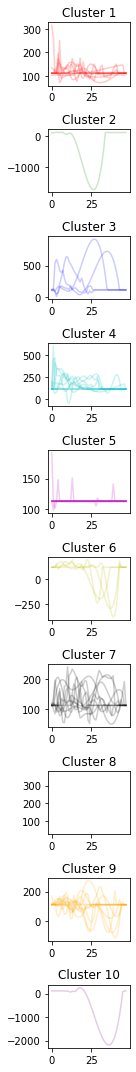

In [65]:
colours = {0:'r', 1:'g', 2:'b', 3:'c', 4:'m', 5:'y', 6:'k', 7:'w', 8:'orange', 9:'purple', 10:'pink'}


fig = plt.figure(figsize=(2,15))

for i in range(clusters):
    plt.subplot(clusters, 1, i+1)
    for sample in dataFormatted[y_pred == i][:10]:
        plt.plot(sample, c=colours[i], alpha=0.2)
    plt.title(f"Cluster {i+1}")

plt.tight_layout()

print(silhouette_score(data, y_pred))